In [1]:
import os
import re
import sys
import glob
import pickle
from time import strftime, localtime

import numpy as np
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt
plt.rc('font', **{'family': 'sans-serif', 'size': 9})

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

In [2]:
def plot_data(data_folder, H_values, gen_id=None, area_id=None, gen_areas_map=None, gen_Pnom=None,
              bus_id=None, xlim_distr = None, ylim=[-4,4]):
    if gen_id is None and (bus_id is None or area_id is None):
        raise Exception('One of gen_id or (bus_id,area_id) must be not None')
    if gen_id is not None and (bus_id is not None or area_id is not None):
        raise Exception('One of gen_id or (bus_id,area_id) must be None')

    H_values = np.array(H_values)
    
    if gen_id is not None:
        var_names = tuple(var_name.format(gen_id) for var_name in ('omega_G{}','Pe_G{}'))
        inertia = {'training': H_values}
        time, x, y = load_data_generators([data_folder], [gen_id], inertia, var_names,
                                          max_block_size=500, use_tf=False)
        idx_min, _ = np.where(y['training'] == H_values.min())
        idx_max, _ = np.where(y['training'] == H_values.max())
        inertia_units = 's'
    else:
        area_inertia = 'energy'
        inertia_units = 'GW s'
        inertia_units
        data_files = []
        for data_file in glob.glob(data_folder + '/*_training_set.h5'):
            _, _, areas_H = read_inertia_values(data_file, gen_areas_map, gen_Pnom, area_inertia)
            H = areas_H[area_id]
            if H in H_values:
                data_files.append(data_file)
        var_names = tuple(var_name.format(bus_id) for var_name in ('omegael_bus{}','Pe_bus{}'))
        time, x, y = load_data_areas({'training': data_files}, var_names, gen_areas_map, gen_Pnom,
                                     area_inertia, max_block_size=1000, use_tf=False)
        idx_min, _ = np.where(y['training'] == H_values.min())
        idx_max, _ = np.where(y['training'] == H_values.max())

    x_train_mean = np.mean(x['training'], axis=(1,2))
    x_train_std = np.std(x['training'], axis=(1,2))
    for i,(m,s) in enumerate(zip(x_train_mean, x_train_std)):
        x['training'][i,:,:] = (x['training'][i,:,:] - m) / s
    
    fig = plt.figure(figsize=(11,4))
    gs = fig.add_gridspec(2, 4)
    ax = [
        fig.add_subplot(gs[0,:2]),
        fig.add_subplot(gs[1,:2]),
        fig.add_subplot(gs[0,2]),
        fig.add_subplot(gs[1,2]),
        fig.add_subplot(gs[0,3]),
        fig.add_subplot(gs[1,3])
    ]

    if xlim_distr is not None:
        lim = xlim_distr
    else:
        lim = 0
    
    # variables used in FFT computation
    block_size = 5
    N_samples = block_size * x['training'].shape[-1]
    dt = np.diff(time[:2])[0]
    freq = fftfreq(N_samples, dt)[:N_samples//2]
        
    cmap = [[0.2,0.8,0.2], [0.8,0.2,0.8]] 
    for i in range(2):
        ### actual traces
        ax[i].plot(time, x['training'][i, idx_min[:5], :].T, color=cmap[0], lw=1)
        ax[i].plot(time, x['training'][i, idx_max[:5], :].T, color=cmap[1], lw=1)

        ### distributions
        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:][idx_min,:]), \
                               bins=100, range=ylim, density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], color=cmap[0], linewidth=1.2)
        n,edges = np.histogram(np.ndarray.flatten(x['training'][i,:,:][idx_max,:]), \
                               bins=100, range=ylim, density=True)
        lim = n.max() if n.max() > lim else lim
        ax[i+2].plot(n, edges[:-1], color=cmap[1], linewidth=1.2, label=f'H={H_values[1]:g} {inertia_units}')
        ax[i+2].set_yticklabels([])
        
        ### FFTs
        N_traces = idx_min.size // block_size
        Xf = np.zeros((N_traces, N_samples), dtype=np.complex64)
        for j in range(N_traces):
            start_trace = j * block_size
            X = np.vstack(x['training'][i, idx_min[start_trace : start_trace + block_size], :]).flatten()
            Xf[j,:] = fft(X)
        Xf = 2.0 / N_samples * np.abs(Xf[:, 0 : N_samples // 2])
        ax[i+4].semilogy(freq, Xf.mean(axis=0), color=cmap[0], lw=1, label=f'H={H_values[0]:g} {inertia_units}')
        N_traces = idx_max.size // block_size
        Xf = np.zeros((N_traces, N_samples), dtype=np.complex64)
        for j in range(N_traces):
            start_trace = j * block_size
            X = np.vstack(x['training'][i, idx_max[start_trace : start_trace + block_size], :]).flatten()
            Xf[j,:] = fft(X)
        Xf = 2.0 / N_samples * np.abs(Xf[:, 0 : N_samples // 2])
        ax[i+4].semilogy(freq, Xf.mean(axis=0), color=cmap[1], lw=1, label=f'H={H_values[1]:g} {inertia_units}')
        
    ax[2].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])
    ax[3].plot([0, lim*1.05], [0,0], '--', lw=1, color=[.6,.6,.6])

    for a in ax:
        for side in 'right', 'top':
            a.spines[side].set_visible(False)

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[2].get_shared_x_axes().join(ax[2], ax[3])
    ax[0].get_shared_y_axes().join(ax[0], ax[2])
    ax[1].get_shared_y_axes().join(ax[1], ax[3])
    ax[0].set_ylim(ylim)
    ax[1].set_ylim(ylim)

    for i in 4,5:
        ax[i].set_xlabel('Frequency [Hz]')
        ax[i].set_ylabel('Magnitude')

    if gen_id is not None:
        ax[0].set_ylabel(r'Norm. $\omega_{\mathrm{G}_%d}$' % gen_id)
        ax[1].set_ylabel(r'Norm. P$_{\mathrm{e,G}_%d}$' % gen_id)
    else:
        ax[0].set_ylabel(r'Norm. $\omega_{\mathrm{e,bus}_%d}$' % bus_id)
        ax[1].set_ylabel(r'Norm. P$_{\mathrm{e,bus}_%d}$' % bus_id)
    ax[1].set_xlabel('Time [s]')
    ax[3].set_xlabel('Fraction')
    ax[4].legend(loc='upper right')
    fig.tight_layout()
    if gen_id is not None:
        fig.savefig(data_folder + f'/generator_{gen_id}.pdf');
    else:
        fig.savefig(data_folder + f'/bus_{bus_id}.pdf');

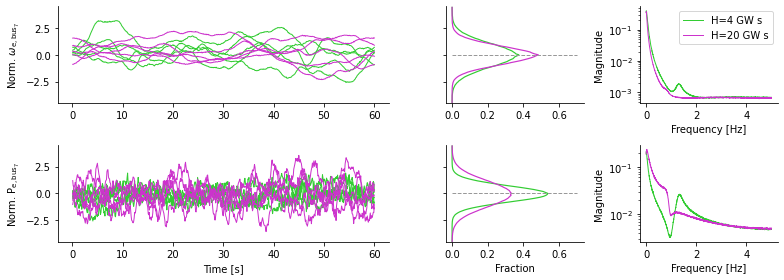

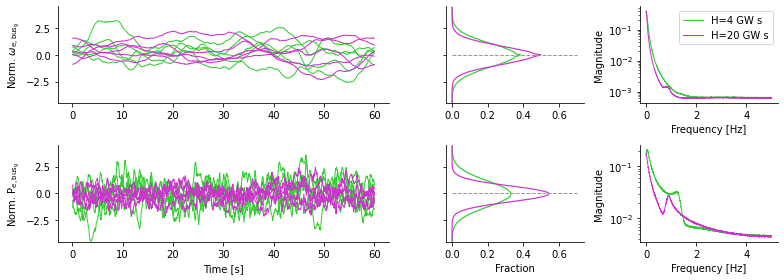

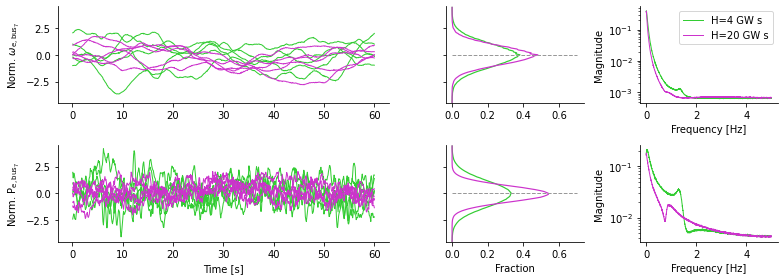

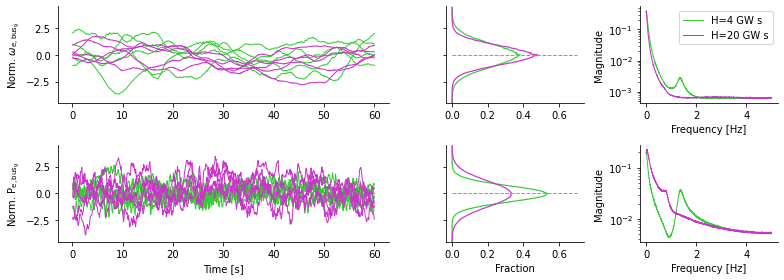

In [3]:
for area in 1,2:
    data_folder = f'../data/two-area/var_H_area_{area}/two-area_D=2_DZA=60.0/'
    for bus in 7,9:
        plot_data(data_folder, bus_id=bus, area_id=area-1, gen_areas_map=[['G1', 'G2'], ['G3', 'G4']],
                  gen_Pnom={f'G{i+1}': 1e9 for i in range(4)}, H_values=[4,20], xlim_distr = 0.67, ylim=[-4.5,4.5])

## IEEE39

In [4]:
bus_IDs = 3, 14, 17, 39
bus_id = bus_IDs[0]
area = 1
data_folder = f'../data/IEEE39/var_H_area_{area}/IEEE39_D=2_DZA=60.0/'
gen_areas_map = [['Pg31','Pg32','Pg39'], ['Pg33','Pg34','Pg35','Pg36'], ['Pg37','Pg38','Pg30']]
gen_Pnom = {gen: 100e6 for area in gen_areas_map for gen in area}
area_inertia = 'energy'
print(' ' * 49 + '{:^14s}'.format('INERTIA'))
print('{:^48s} {:^4s} {:^4s} {:^4s}'.format('Filename', 'A1','A2','A3'))
print('=' * 63)
for data_file in glob.glob(data_folder + '/*_training_set.h5'):
    gen_IDs, gen_H, area_H = read_inertia_values(data_file, gen_areas_map, gen_Pnom, area_inertia)
    a,b = os.path.basename(data_file)[:30], os.path.basename(data_file)[-15:]
    print(f'{a}...{b} {area_H[0]:4.1f} {area_H[1]:4.1f} {area_H[2]:4.1f}')

                                                    INERTIA    
                    Filename                      A1   A2   A3 
inertia_250.000_19.000_23.000_...training_set.h5  5.8  5.8 27.9
inertia_250.000_16.000_12.000_...training_set.h5  4.6  5.8 27.9
inertia_250.000_18.000_20.000_...training_set.h5  6.4  5.8 27.9
inertia_250.000_10.000_14.000_...training_set.h5  4.0  5.8 27.9
inertia_250.000_12.000_14.000_...training_set.h5  4.3  5.8 27.9
inertia_250.000_20.000_16.000_...training_set.h5  6.1  5.8 27.9
inertia_250.000_21.000_23.000_...training_set.h5  7.0  5.8 27.9
inertia_250.000_21.000_19.000_...training_set.h5  6.7  5.8 27.9
inertia_250.000_11.000_21.000_...training_set.h5  5.2  5.8 27.9
inertia_250.000_12.000_19.000_...training_set.h5  4.9  5.8 27.9
inertia_250.000_16.000_16.000_...training_set.h5  5.5  5.8 27.9


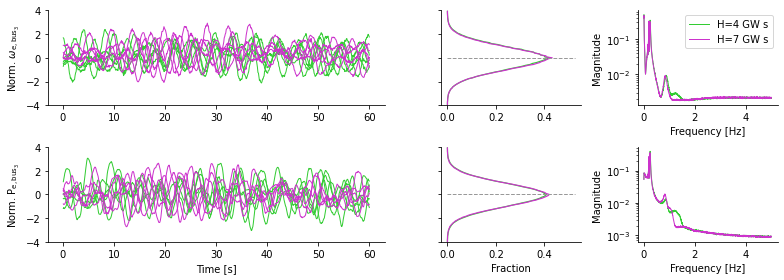

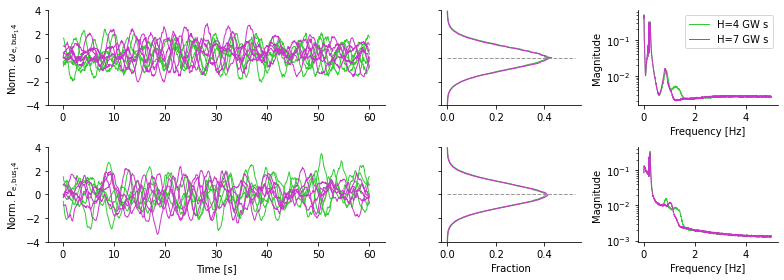

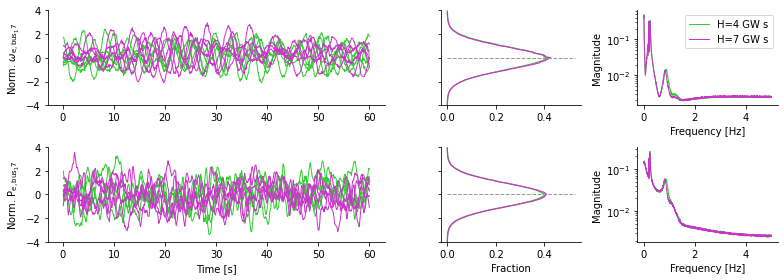

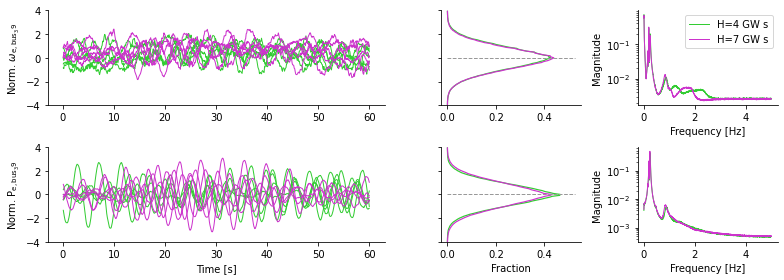

In [5]:
for bus in 3, 14, 17, 39:
    plot_data(data_folder, bus_id=bus, area_id=0, gen_areas_map=gen_areas_map,
            gen_Pnom=gen_Pnom, H_values=[4,7], xlim_distr = 0.5, ylim=[-4,4])